In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, AveragePooling2D
from keras.optimizers import Adam
import cv2
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
import scipy.fftpack as fp
from skimage.io import imread
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


In [9]:
tp = pd.read_csv('tp_list.txt', header=None)
au = pd.read_csv('au_list.txt', header=None)
file_path_au = "C:\\Users\\jakub\\Desktop\\Au"
file_path_tp = "C:\\Users\\jakub\\Desktop\\Tp"
au[0] = file_path_au + "\\" + au[0]
tp[0] = file_path_tp + "\\" + tp[0]
au.columns = ['file_path']
tp.columns = ['file_path']
au['type'] = 'Authentic'
tp['type'] = 'Forged'

In [10]:
im_df = pd.concat([au, tp], ignore_index=True)

In [3]:
def preprocess_image(image_path, output_size=(224, 224), jpg_quality = 95):
    # Wczytanie obrazu w trybie kolorowym (RGB)
    img = cv2.imread(image_path)
    img = cv2.resize(img, output_size)  # Skalowanie do (224, 224)
    
    # Zapisanie obrazu do pamięci (w formacie JPEG)
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), jpg_quality]
    _, encoded_img = cv2.imencode('.jpg', img, encode_param)

    # Odczytanie skompresowanego obrazu z pamięci
    compressed_img = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)

    ela_diff = cv2.absdiff(img, compressed_img)
    max_diff = np.max(ela_diff)
    scale = 255 / max_diff if max_diff > 0 else 1
    ela = ela_diff * scale
    ela = np.uint8(ela)
    return ela

In [12]:
def save_image():
    labels = []
    imgs = []
    
    for i in range(len(im_df)):
        labels.append(im_df['type'][i]) 
        img_ela = preprocess_image(im_df['file_path'][i]) 
        imgs.append(img_ela)
    
    return labels, imgs

In [13]:
#odzyskiwanie ramu
del tp
del au
del file_path_au
del file_path_tp

In [14]:
labels, imgs = save_image()

In [15]:
#odzyskiwanie ramu
del im_df

In [16]:
u = list(np.unique(labels)) #lsita unikalnych wartości w labels (red, green, other)

ilabels = np.asarray([u.index(l) for l in labels]) #utworzenie nowej listy zawierającyh wartości unikalne w postaci liczb, a nie tekstu

In [17]:
#odzyskiwanie ramu
del u
del labels

Kodu niżej nie uruchmiać jeśli nie ma się 32 GB RAMU, bo freezuje komputer

In [18]:
X = np.stack(imgs) / 255.0 - 0.5 #połączenie wszystkich osobnych list zawarty w imgs w jedną podzielenie wartości przez 255, ay otrzymać wartości od 0 do 1 i pomniejszenie wartości o 0.5 i otrzymanie od -0.5 do 0.5

In [19]:
del imgs

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, ilabels, test_size=0.33, shuffle=True, random_state=42) #podzielenie danych na treningowe i testowe, jak wyżej

In [21]:
del X
del ilabels

In [22]:
# Tworzenie modelu Sequential
input_shape = (224, 224, 3)

# Define the CNN model
model = Sequential([
        # Pierwsza warstwa splotowa
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),

        # Druga warstwa splotowa
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Trzecia warstwa splotowa
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Czwarta warstwa splotowa
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Dropout(0.5),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),

        # Output layer
        Dense(1, activation='sigmoid')
])

# Kompilacja modelu z dodatkowymi metrykami
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-3),
              metrics=['accuracy', AUC(name="AUC"), Precision(name="Precision"), Recall(name="Recall"), keras.metrics.TruePositives(name="TP"), keras.metrics.TrueNegatives(name="TN")])

# Podsumowanie modelu
model.summary()

c:\Users\jakub\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,107,265 (19.48 MB)

 Trainable params: 5,107,265 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
h = model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=2, validation_data=(X_test, y_test))

Epoch 1/20
265/265 - 97s - 367ms/step - AUC: 0.7594 - Precision: 0.6650 - Recall: 0.5476 - TN: 4043.0000 - TP: 1892.0000 - accuracy: 0.7023 - loss: 0.5762 - val_AUC: 0.8192 - val_Precision: 0.6831 - val_Recall: 0.6876 - val_TN: 1963.0000 - val_TP: 1147.0000 - val_accuracy: 0.7471 - val_loss: 0.5133
Epoch 2/20
265/265 - 89s - 334ms/step - AUC: 0.7919 - Precision: 0.6783 - Recall: 0.6718 - TN: 3895.0000 - TP: 2321.0000 - accuracy: 0.7355 - loss: 0.5439 - val_AUC: 0.8177 - val_Precision: 0.6985 - val_Recall: 0.6403 - val_TN: 2034.0000 - val_TP: 1068.0000 - val_accuracy: 0.7451 - val_loss: 0.5140
Epoch 3/20
265/265 - 93s - 350ms/step - AUC: 0.8144 - Precision: 0.6994 - Recall: 0.7097 - TN: 3942.0000 - TP: 2452.0000 - accuracy: 0.7566 - loss: 0.5172 - val_AUC: 0.8372 - val_Precision: 0.7159 - val_Recall: 0.7038 - val_TN: 2029.0000 - val_TP: 1174.0000 - val_accuracy: 0.7694 - val_loss: 0.4844
Epoch 4/20
265/265 - 93s - 351ms/step - AUC: 0.8177 - Precision: 0.6962 - Recall: 0.7030 - TN: 3936.

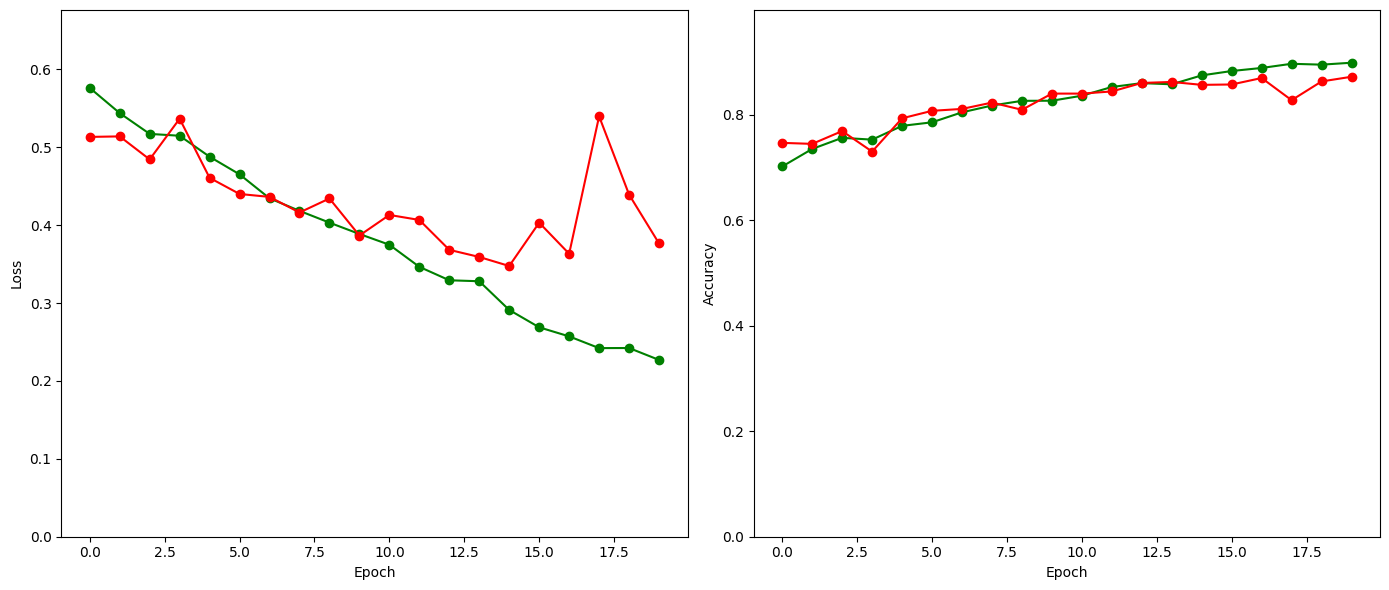

Training history with confidence intervals saved as training_ela_rgb.svg


In [24]:
# Tworzenie DataFrame z historii trenowania
history_df = pd.DataFrame(h.history)

# Obliczanie przedziałów ufności (np. 95%)
confidence_interval = 0.95
ci_bounds = int((1 - confidence_interval) * 100 / 2)

# Funkcja do obliczania przedziału ufności
def compute_confidence_interval(values):
    mean = np.mean(values)
    std = np.std(values)
    ci_range = std * 1.96  # 95% przedział ufności
    return mean - ci_range, mean + ci_range

# Tworzenie wykresów
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Wykres dla loss
axes[0].plot(history_df['loss'], label='Loss', color='green', marker='o')
axes[0].plot(history_df['val_loss'], label='Loss', color='red', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_ylim(0, max(history_df[['loss', 'val_loss']].max()) + 0.1)  # Skala od 0

# Wykres dla accuracy
axes[1].plot(history_df['accuracy'], label='Accuracy', color='green', marker='o')
axes[1].plot(history_df['val_accuracy'], label='Accuracy', color='red', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0, max(history_df[['accuracy', 'val_accuracy']].max()) + 0.1)  # Skala od 0
# Zapis do pliku SVG
plt.tight_layout()
plt.savefig('training_ela_rgb.svg', format='svg')
plt.show()

print("Training history with confidence intervals saved as training_ela_rgb.svg")


In [25]:
history_df.to_csv('ela_rgb.csv', index=False)

In [26]:
history_df

,AUC,Precision,Recall,TN,TP,accuracy,loss,val_AUC,val_Precision,val_Recall,val_TN,val_TP,val_accuracy,val_loss
0,0.759413,0.665026,0.547612,4043.0,1892.0,0.702284,0.576237,0.819237,0.683145,0.687650,1963.0,1147.0,0.747057,0.513310
1,0.791927,0.678258,0.671780,3895.0,2321.0,0.735534,0.543856,0.817705,0.698496,0.640288,2034.0,1068.0,0.745136,0.513962
2,0.814418,0.699373,0.709696,3942.0,2452.0,0.756597,0.517178,0.837182,0.715854,0.703837,2029.0,1174.0,0.769397,0.484389
3,0.817709,0.696188,0.703039,3936.0,2429.0,0.753165,0.514788,0.829506,0.613940,0.881894,1570.0,1471.0,0.730483,0.536661
4,0.836777,0.720588,0.751664,3989.0,2597.0,0.779316,0.487873,0.858865,0.702149,0.842326,1899.0,1405.0,0.793658,0.460762
5,0.852932,0.723110,0.772504,3974.0,2669.0,0.786061,0.465227,0.871648,0.762077,0.756595,2101.0,1262.0,0.807831,0.440034
6,0.872588,0.744652,0.795948,4053.0,2750.0,0.804994,0.434472,0.880718,0.716316,0.876499,1916.0,1462.0,0.811434,0.436288
7,0.879851,0.753038,0.825181,4061.0,2851.0,0.817891,0.418387,0.892535,0.791017,0.760192,2160.0,1268.0,0.823445,0.416236
8,0.889340,0.763429,0.835022,4102.0,2885.0,0.826766,0.403238,0.883430,0.698190,0.925060,1828.0,1543.0,0.809753,0.434250
9,0.896873,0.759033,0.845152,4069.0,2920.0,0.827003,0.388694,0.894760,0.765328,0.868106,2051.0,1448.0,0.840500,0.386704


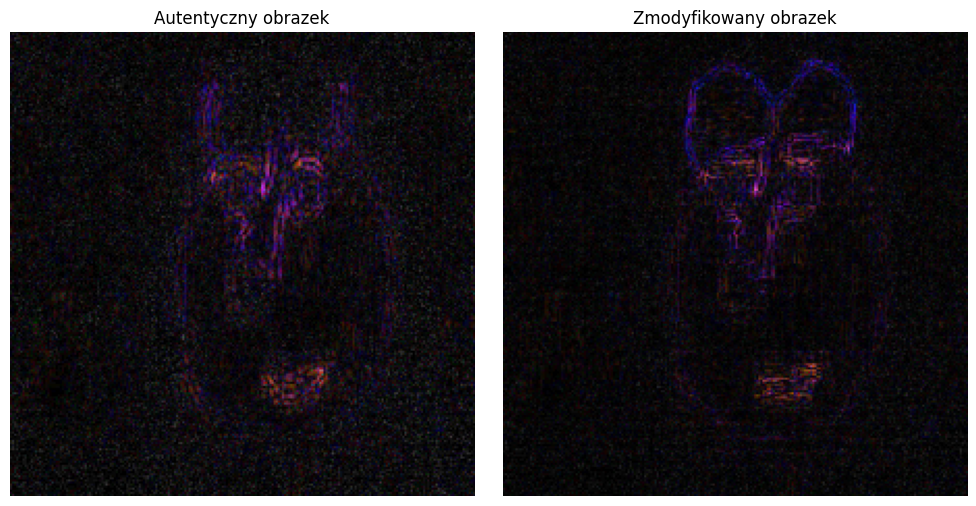

In [4]:
# Ścieżki do obrazów
image_path1 = "C:\\Julia\\Studia\\CASIA2.0_revised\\Au\\Au_art_00011.jpg"
image_path2 = "C:\\Julia\\Studia\\CASIA2.0_revised\\Tp\\Tp_D_CNN_S_N_art00011_art00014_11841.jpg"

# Przetwarzanie obrazów
processed_image1 = preprocess_image(image_path1)
processed_image2 = preprocess_image(image_path2)

# Wyświetlanie obrazów
plt.figure(figsize=(10, 5))

# Obraz 1
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(processed_image1, cv2.COLOR_BGR2RGB))
plt.title('Autentyczny obrazek')
plt.axis('off')

# Obraz 2
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(processed_image2, cv2.COLOR_BGR2RGB))
plt.title('Zmodyfikowany obrazek')
plt.axis('off')

plt.tight_layout()
plt.savefig('ela_rgb.svg', format='svg')
plt.show()
